Need to clone lsst/throughputs and setenv THROUGHPUTS_DIR to point to that directory first.

In [1]:
from collections import OrderedDict as odict

import sncosmo
import analyzeSN as ans

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Comparison of model and simulated data
We already know how to extract the data from the simulations. The data is the model light curve + noise. The model used here is SALT2, which has a few parameters ['x0', 'x1', 'c', 'z', 't0']. We must estimate the values of these parameters from the data

In [2]:
simdata = ans.SNANASims.fromSNANAfileroot('LSST_Ia', location='ENIGMA_LSSTMAIN/', coerce_inds2int=False)
print simdata.headData.shape

(1622, 78)


Find SNe with large numbers of observations (for demonstration)

In [3]:
nobs = [simdata.get_SNANA_photometry(snid=snid).lightCurve.shape[0] for snid in simdata.headData.index.values]

In [4]:
print np.array(nobs).max()
snid = simdata.headData.index.values[np.argmax(np.array(nobs))]
print snid

71
3942


In [5]:
#hd = simdata.headData.query('REDSHIFT_FINAL > 0.2 and REDSHIFT_FINAL < 0.25').head(5).copy()
hd = simdata.headData.query('NOBS > 50').head(5).copy()
#hd = simdata.headData.query('REDSHIFT_FINAL < 0.1').head(5).copy()
#snid = hd.index.values[2]
print snid
hd

3942


,IAUC,FAKE,RA,DECL,PIXSIZE,NXPIX,NYPIX,SNTYPE,NOBS,PTROBS_MIN,...,SIM_EXPOSURE_r,SIM_EXPOSURE_i,SIM_EXPOSURE_z,SIM_EXPOSURE_Y,SIM_GALFRAC_u,SIM_GALFRAC_g,SIM_GALFRAC_r,SIM_GALFRAC_i,SIM_GALFRAC_z,SIM_GALFRAC_Y
SNID,,,,,,,,,,,,,,,,,,,,,
3942,NULL,2,0.000000,-0.794553,0.2,-9,-9,1,71,5757,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
14174,NULL,2,2.646689,-0.355408,0.2,-9,-9,1,51,20809,...,1.0,1.0,1.0,1.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [6]:
lcobj = simdata.get_SNANA_photometry(snid=snid)
print lcobj.lightCurve.shape
#lcobj.lightCurve

(71, 22)


In [7]:
print simdata.headData.ix[snid]
hd['SIM_SALT2x0'] = hd.SIM_SALT2x0 * 10.0**(-0.4 * 0.27)
hd['params'] = hd[['SIM_PEAKMJD', 'SIM_SALT2x0', 'SIM_SALT2x1', 'SIM_SALT2c', 'REDSHIFT_FINAL', ]].rename(columns=dict(SIM_PEAKMJD='t0', 
                                                                                    SIM_SALT2x0='x0',
                                                                                    SIM_SALT2x1='x1',
                                                                                    SIM_SALT2c='c',
                                                                                    SIM_MWEBV='ebv',                                   
                                                                                    REDSHIFT_FINAL='z')).apply(odict, axis=1)

IAUC                      NULL    
FAKE                             2
RA                               0
DECL                     -0.794553
PIXSIZE                        0.2
NXPIX                           -9
NYPIX                           -9
SNTYPE                           1
NOBS                            71
PTROBS_MIN                    5757
PTROBS_MAX                    5827
MWEBV                         0.01
MWEBV_ERR                   0.0016
REDSHIFT_HELIO            0.774001
REDSHIFT_HELIO_ERR          0.0005
REDSHIFT_FINAL            0.771876
REDSHIFT_FINAL_ERR          0.0005
HOSTGAL_OBJID                12333
HOSTGAL_PHOTOZ            0.764214
HOSTGAL_PHOTOZ_ERR           0.014
HOSTGAL_SPECZ                    0
HOSTGAL_SPECZ_ERR                0
HOSTGAL_SNSEP                 -999
HOSTGAL_LOGMASS                 -9
HOSTGAL_LOGMASS_ERR             -9
HOSTGAL_MAG_u                  999
HOSTGAL_MAG_g                  999
HOSTGAL_MAG_r                  999
HOSTGAL_MAG_i       

In [8]:
hd['params'].ix[snid]

OrderedDict([('t0', 52534.863),
             ('x0', 3.3000356e-06),
             ('x1', 0.7941221),
             ('c', 0.042838477),
             ('z', 0.77187568)])

In [9]:
dust = sncosmo.CCM89Dust()
model = sncosmo.Model(source='salt2-extended', effects=[dust, dust], 
                     effect_names=['host', 'mw'], effect_frames=['rest', 'obs'])
model.set(**hd.ix[snid].params)

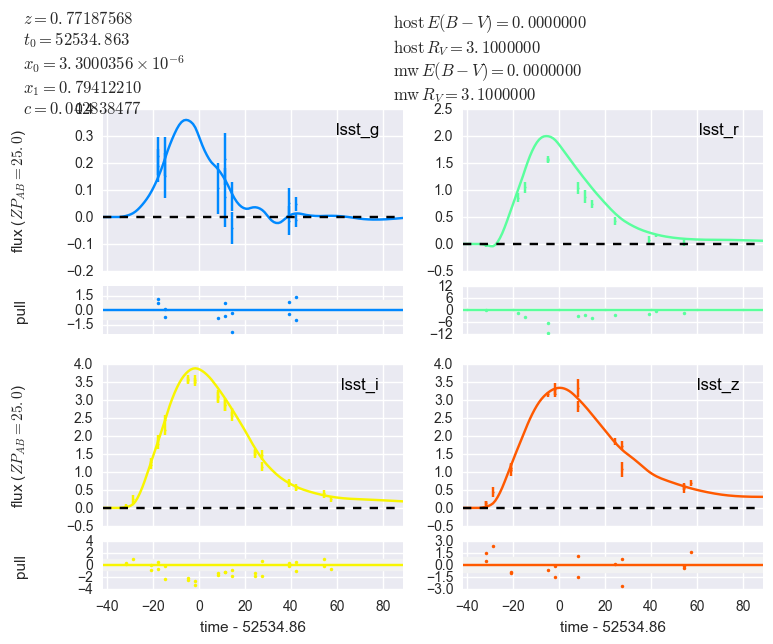

In [10]:
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=model)

### Inferring the model parameters from the data
First we will use a max likelihood method for estimating the model parameters

In [11]:
fitres = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)

In [12]:
print fitres[0].parameters
fitresChar = ans.ResChar.fromSNCosmoRes(fitres)
fitresChar.parameters

[  7.71875679e-01   5.25347521e+04   3.04715181e-06   1.07785611e+00
   1.34853398e-01   0.00000000e+00   3.10000000e+00   0.00000000e+00
   3.10000000e+00]


z              0.771876
t0         52534.752133
x0             0.000003
x1             1.077856
c              0.134853
hostebv        0.000000
hostr_v        3.100000
mwebv          0.000000
mwr_v          3.100000
dtype: float64

In [13]:
fitresChar.vparams

t0    52534.752133
x0        0.000003
x1        1.077856
c         0.134853
dtype: float64

In [14]:
fitresChar.salt_covariance_linear()

,mB,x1,c
mB,0.000676,0.001871,0.000261
x1,0.001871,0.030523,0.000616
c,0.000261,0.000616,0.001676


Errors on model parameters. Including mu.

In [15]:
fitresChar.mu_variance_linear()**0.5

0.12549059972782525

In [16]:
print fitresChar.sncosmoModel.parameters
print fitresChar.sncosmoModel.param_names
#??fitresChar.salt_covariance_linear

[  7.71875679e-01   5.25347521e+04   3.04715181e-06   1.07785611e+00
   1.34853398e-01   0.00000000e+00   3.10000000e+00   0.00000000e+00
   3.10000000e+00]
['z', 't0', 'x0', 'x1', 'c', 'hostebv', 'hostr_v', 'mwebv', 'mwr_v']


### Compute mu from model parameters. 

Notes from Rahul:
    
Yes the issue is with `mB` … the true SALT definition is it is the apparent mag in the BessellB rest frame band.

In the SALT model this turns out to be -2.5 log10(x0) + constant to a very good approximation.

Those numbers come from fitting a sample of SN  (real data) eg JLA.

In [5]:
def computeMu(fitresChar, alpha=0.14, beta=-3.11):
    # mu = alpha * x1 + beta * c + mB + const and set alpha = 0.14, beta = -3.11
    # mB = -2.5 log10(x0) ? (approximately)
    mB = -2.5 * np.log10(fitresChar.parameters['x0'])
    mu = alpha * fitresChar.parameters['x1'] + beta * fitresChar.parameters['c'] + mB #+ const
    return mu

In [18]:
computeMu(fitresChar)

13.52177056055231

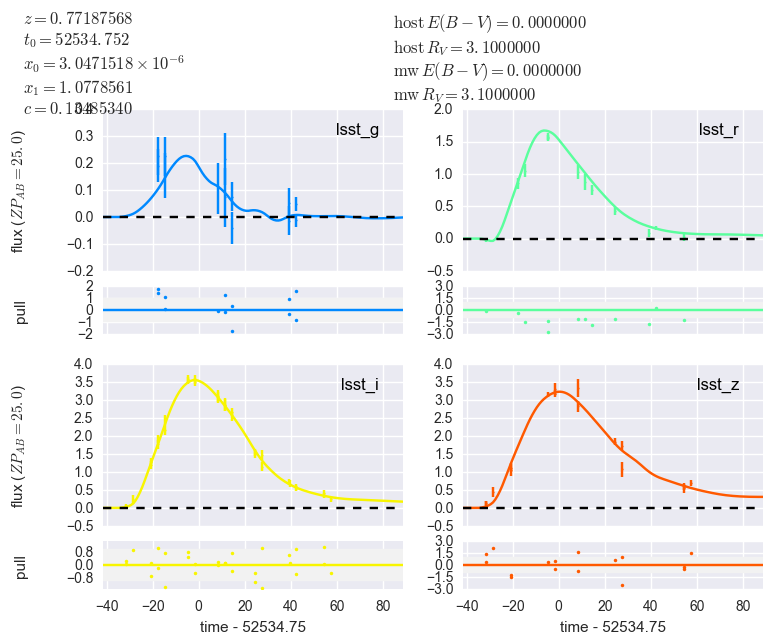

In [19]:
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=fitresChar.sncosmoModel)

### What if we did not know z?

In [20]:
fitres_z = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c', 'z'], guess_z=True, 
                          bounds=dict(z=(0.65, 0.85)),
                          modelcov=True)

In [21]:
fitresChar_z = ans.ResChar.fromSNCosmoRes(fitres_z)
fitresChar_z.parameters

z              0.788165
t0         52534.978648
x0             0.000003
x1             1.086349
c              0.104184
hostebv        0.000000
hostr_v        3.100000
mwebv          0.000000
mwr_v          3.100000
dtype: float64

In [22]:
fitresChar_z.mu_variance_linear()**0.5

0.15256956415820788

13.6186340447


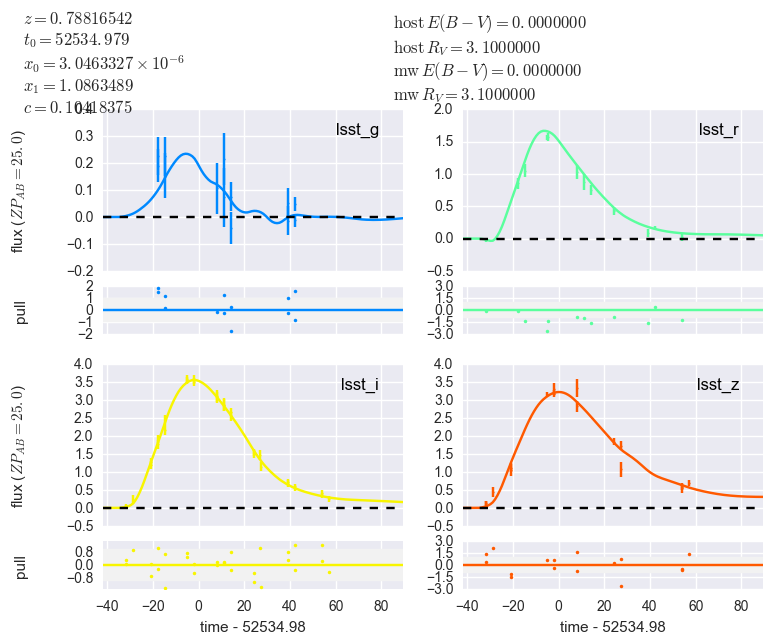

In [23]:
print computeMu(fitresChar_z)
_ = sncosmo.plot_lc(lcobj.snCosmoLC(), model=fitresChar_z.sncosmoModel)

### Now we repeat this in a different method
The maximum likelihood method above is not good if the likelihood are too far from the Gaussian. A method to sample posteriors is better. Such a method can be based on a MCMC run. We do that here by the following code

These are samples of these parameters :

### Fit all of the SNe.

In [7]:
## Capture verbose output so it's not printed.
## See: http://stackoverflow.com/questions/16571150/how-to-capture-stdout-output-from-a-python-function-call
## Note this is not thread-safe so I just edited the code for ans.mu_variance_linear()
from cStringIO import StringIO
import sys

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        sys.stdout = self._stdout

def computeMu(fitresChar, alpha=0.14, beta=-3.11):
    # mu = alpha * x1 + beta * c + mB + const and set alpha = 0.14, beta = -3.11
    # mB = -2.5 log10(x0) ? (approximately)
    mB = -2.5 * np.log10(fitresChar.parameters['x0'])
    mu = alpha * fitresChar.parameters['x1'] + beta * fitresChar.parameters['c'] + mB #+ const
    return mu

def fitSN(snid, verbose=False, plot=False):
    outParams = None
    try:
        lcobj = simdata.get_SNANA_photometry(snid=snid)
        if verbose:
            print snid, lcobj.lightCurve.shape[0]
        hd = simdata.headData.copy() #simdata.headData.query('SNID == %s' % snid).head(5).copy()
        hd['SIM_SALT2x0'] = hd.SIM_SALT2x0 * 10.0**(-0.4 * 0.27)
        hd['params'] = hd[['SIM_PEAKMJD', 'SIM_SALT2x0', 'SIM_SALT2x1', 'SIM_SALT2c', 'REDSHIFT_FINAL', ]].rename(columns=dict(SIM_PEAKMJD='t0', 
                                                                            SIM_SALT2x0='x0',
                                                                            SIM_SALT2x1='x1',
                                                                            SIM_SALT2c='c',
                                                                            SIM_MWEBV='ebv',                                   
                                                                            REDSHIFT_FINAL='z')).apply(odict, axis=1)
        dust = sncosmo.CCM89Dust()
        model = sncosmo.Model(source='salt2-extended', effects=[dust, dust], 
                         effect_names=['host', 'mw'], effect_frames=['rest', 'obs'])
        model.set(**hd.ix[snid].params)
        if plot:
            sncosmo.plot_lc(lcobj.snCosmoLC(), model=model)
        fitres = sncosmo.fit_lc(lcobj.snCosmoLC(), model=model, vparam_names=['t0', 'x0', 'x1', 'c'], modelcov=True)
        fitresChar = ans.ResChar.fromSNCosmoRes(fitres)
        outParams = fitresChar.parameters.copy()
        outParams['mu'] = computeMu(fitresChar)
        #with Capturing() as output:
        outParams['mu_var'] = fitresChar.mu_variance_linear()**0.5
        outParams['inputParams'] = hd['params'].ix[snid]
    except Exception as e:
        if verbose:
            print snid, e
        pass
        #raise e
    return outParams

In [8]:
print fitSN(snid)

z                                                       0.771876
t0                                                       52534.8
x0                                                   3.04716e-06
x1                                                       1.07809
c                                                        0.13487
hostebv                                                        0
hostr_v                                                      3.1
mwebv                                                          0
mwr_v                                                        3.1
mu                                                       13.5217
mu_var                                                  0.125494
inputParams    {u't0': 52534.9, u'x0': 3.30004e-06, u'x1': 0....
dtype: object


In [ ]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import gzip, cPickle
#snFits = Parallel(n_jobs=num_cores, verbose=2)(delayed(fitSN)(id, verbose=True) \
#                                               for id in simdata.headData.index.values)
#snFits = {id: fitSN(id, verbose=True) for id in simdata.headData.index.values}
snFits = {}
for id in simdata.headData.index.values:
    snFits[id] = fitSN(id, verbose=True)
    cPickle.dump(snFits, gzip.GzipFile('snFits.p.gz', 'wb'))

3
3 6
4 28
47 22
50 17
74 27
84 30
89 23
95 16
97 6
106 13
117 27
126 36
129 15
140 12
150 17


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.011432
         t0 = +50187.933716
         x0 = +0.024500
         x1 = -194.148162
          c = -64.356096
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


150 fcn returns Nan
fcn is called with following arguments:
          z = +1.011432
         t0 = +50187.933716
         x0 = +0.024500
         x1 = -194.148162
          c = -64.356096
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

152 25
194 28
206 31


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.012637
         t0 = +51889.456047
         x0 = +13597379085.573263
         x1 = +123.899479
          c = +1901.900176
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


206 fcn returns Nan
fcn is called with following arguments:
          z = +1.012637
         t0 = +51889.456047
         x0 = +13597379085.573263
         x1 = +123.899479
          c = +1901.900176
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

290 32


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +1.069105
         t0 = +50911.872720
         x0 = -498826.361018
         x1 = +139024703731.953491
          c = -83601925354.635773
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


290 fcn returns Nan
fcn is called with following arguments:
          z = +1.069105
         t0 = +50911.872720
         x0 = -498826.361018
         x1 = +139024703731.953491
          c = -83601925354.635773
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

316 7
320 28
333 13
354 30
369 26
380 24
407 11
441 25
499 21
528 29
571 23
575 33
578 31
596 36
629 21
632 19
714 25
736 11
747 37
752 37
755 22
784 35
795 18
821 27
851 31
862 26
873 22
873 No data points with S/N > 5.0. Initial guessing failed.
926 28
955 15
963 18
973 28
974 24
980 38
981 34
986 14
1014 31
1028 28
1042 21
1050 35
1053 21
1061 25
1089 28
1094 18
1103 18
1187 12
1188 23
1196 31
1216 21
1217 40
1234 39
1269 29
1326 27
1339 27
1364 36
1422 11
1439 26
1445 5
1447 21
1457 34


/Users/dreiss/store/miniconda/lib/python2.7/site-packages/sncosmo/fitting.py:429: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.843532
         t0 = +51408.944832
         x0 = +446137661254.639160
         x1 = +1059.866631
          c = +69953.807005
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)


1457 fcn returns Nan
fcn is called with following arguments:
          z = +0.843532
         t0 = +51408.944832
         x0 = +446137661254.639160
         x1 = +1059.866631
          c = +69953.807005
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.000000
      mwr_v = +3.100000

1461 20
1479 34
1500 27
1513 23
1518 39
1551 24
1583 26
1678 33
1685 34
1686 41
1688 15
1701 32
1708 19
1708 No data points with S/N > 5.0. Initial guessing failed.
1709 15
1723 32
1734 23
1736 12
1764 12
1769 40
1770 29
1779 17
1784 47


/Users/dreiss/Desktop/Pre_MAP/store/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


1807 11
1854 19
1895 30
1911 16
1921 29
1934 8
1972 11
1975 9
1988 6
1997 15
2026 23
2038 26
2053 35
2069 34
2112 23
2116 38
2122 7
2126 14
2157 27
2164 29
2168 36
2180 23
2186 12
2216 19
2233 27
2236 8
2284 29
2289 16
2290 32
2295 6
2342 34
2343 17
2357 6
2408 45
2409 25
2450 11
2453 26
